<a href="https://colab.research.google.com/github/VictorCampelo/Cluster-Labeler-Using-CAIM-Discretizer/blob/master/CAIBAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install caimcaim
!pip3 install kneed
!pip3 install sklearn -U

  Created wheel for caimcaim: filename=caimcaim-0.3-cp36-none-any.whl size=3867 sha256=9757b409e6e302e692d0eea0aa9e6df1a2b19a267af5e7f2fcfed262f7ca9a8c
  Stored in directory: /root/.cache/pip/wheels/54/3f/ba/93c91435291033291bd84bda3b3fe1e725c6f62246040ec4f1
Successfully built caimcaim
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
#importing the libraries
from caimcaim import CAIMD
from itertools import compress 
from kneed import KneeLocator
from itertools import cycle, islice

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, \
estimate_bandwidth, SpectralClustering, AgglomerativeClustering, Birch
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from yellowbrick.cluster import InterclusterDistance

from numpy import unique
from numpy import where

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.metrics import homogeneity_completeness_v_measure
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle

In [4]:
#importing the Iris dataset with pandas
iris = load_iris()
digt = load_digits()
wine = load_wine()
canc = load_breast_cancer()

df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_digt = pd.DataFrame(digt.data)
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_canc = pd.DataFrame(canc.data, columns=canc.feature_names)

In [5]:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
df_digt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [7]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [8]:
df_canc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
def preProcess(X):
  # Standardize data
  # Normalizing the Data
  # Converting the numpy array into a pandas DataFrame
  scaler = StandardScaler()
  return normalize(scaler.fit_transform(X))

In [10]:
def PCARedution(X):
  # Reducing the dimensions of the data 
  pca = PCA(n_components = 2) 
  X1 = pca.fit_transform(X)
  return X1

In [11]:
def Elbow_kneeLocator(X):
  X = preProcess(X)
  X = PCARedution(X)
  clusters = []

  best_n_clusters = 0
  best_sil = 0
  for i in range(1, 11):
      km = KMeans(n_clusters=i).fit(X)
      clusters.append(km.inertia_)
      labels = km.labels_
      if len(set(labels)) <= 1: continue
      sil = silhouette_score(X, labels)
      if sil > best_sil:
        best_sil = sil
        best_n_clusters = i
      
  fig, ax = plt.subplots()
  sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
  ax.set_title('Searching for Elbow')
  ax.set_xlabel('Clusters')
  ax.set_ylabel('Inertia')

  plt.show()

  kl = KneeLocator(range(1, 11), 
                   clusters, 
                   curve="convex", 
                   direction="decreasing")
  print("\nResult finding by Knee Locator function: ")
  print(kl.elbow)
  print("\n")
  return best_n_clusters

In [12]:
def clusteringKmeans(X, n_clusters_kl):
  X = preProcess(X)
  X = PCARedution(X)
  model = KMeans(n_clusters=n_clusters_kl).fit(X)
  for cluster in unique(model.labels_):
    # get row indexes for samples with this cluster
    row_ix = where(model.labels_ == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], s=200)
  # show the plot
  plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
              marker='*', s=300,
              c='r', label='centroid')
  plt.show()
  return model.labels_

In [13]:
def clusteringAffinityPropagation(X):
  X = preProcess(X)
  X = PCARedution(X)
  pref = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]
  best_pref = 0
  best_sil = 0
  for i in pref:
    model = AffinityPropagation(preference=i, max_iter=500).fit(X)
    cluster_centers_indices = model.cluster_centers_indices_
    labels = model.labels_

    if len(set(labels)) <= 1: continue
    sil = silhouette_score(X, labels, metric='sqeuclidean')
    if sil > best_sil:
      best_sil = sil
      best_pref = i

  model = AffinityPropagation(preference=best_pref, max_iter=500).fit(X)
  cluster_centers_indices = model.cluster_centers_indices_
  labels = model.labels_

  n_clusters_ = len(cluster_centers_indices)

  print('Estimated number of clusters: %d' % n_clusters_)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      cluster_center = X[cluster_centers_indices[k]]
      plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
      plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
              markeredgecolor='k', markersize=14)
      for x in X[class_members]:
          plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [14]:
def clusteringAgglomerativeClustering (X):
  X = preProcess(X)
  X = PCARedution(X)
  best_n_cluster = 0
  best_sil = 0
  for i in range(1, 11):
    model = AgglomerativeClustering(n_clusters=i).fit(X)
    labels = model.labels_

    if len(set(labels)) <= 1: continue
    sil = silhouette_score(X, labels, metric='sqeuclidean')
    if sil > best_sil:
      best_sil = sil
      best_n_cluster = i

  model = AgglomerativeClustering(n_clusters=best_n_cluster).fit(X)
  labels = model.labels_

  n_clusters_ = model.n_clusters_

  print('Estimated number of clusters: %d' % n_clusters_)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [15]:
def clusteringMeanShift(X):
  X = preProcess(X)
  X = PCARedution(X)
  best_band = 0
  best_sil = 0
  quant = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
  for i in quant:
    bandwidth = estimate_bandwidth(X, quantile=i) # Manually set the quantile to get num clusters = 3

    model = MeanShift(bandwidth=bandwidth).fit(X)
    labels = model.labels_
    cluster_centers = model.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    if len(set(labels)) <= 1: continue
    sil = silhouette_score(X, labels, metric='sqeuclidean')
    if sil > best_sil:
      best_sil = sil
      best_band = bandwidth

  model = MeanShift(bandwidth=best_band, bin_seeding=True).fit(X)
  labels = model.labels_
  cluster_centers = model.cluster_centers_

  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)

  print('Estimated number of clusters: %d' % n_clusters_)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [48]:
def clusteringSpectralClustering(X):
  X = preProcess(X)
  X = PCARedution(X)
  best_n_clusters = 0
  best_sil = 0
  for i in range(1,11):
    model = SpectralClustering(n_clusters=i, random_state=0).fit(X)
    labels = model.labels_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    if len(set(labels)) <= 1: continue
    sil = silhouette_score(X, labels, metric='sqeuclidean')
    if sil > best_sil:
      best_sil = sil
      best_n_clusters = i

  model = SpectralClustering(n_clusters=best_n_clusters, random_state=0).fit(X)
  labels = model.labels_

  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)

  print('Estimated number of clusters: %d' % n_clusters_)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [55]:
def clusteringBirch(X):
  X = preProcess(X)
  X = PCARedution(X)
  best_n_clusters = 0
  best_sil = 0
  for i in range(1,11):
    model = Birch(n_clusters = i).fit(X)
    labels = model.labels_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    if len(set(labels)) <= 1: continue
    sil = silhouette_score(X, labels, metric='sqeuclidean')
    if sil > best_sil:
      best_sil = sil
      best_n_clusters = i

  model = Birch(n_clusters = best_n_clusters).fit(X)
  labels = model.labels_

  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)

  print('Estimated number of clusters: %d' % n_clusters_)
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      plt.scatter(X[class_members, 0], X[class_members, 1], s=200, c=col)
      # plt.plot(X[class_members, 0], X[class_members, 1], col + '.')

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()

  return model.labels_, n_clusters_

In [56]:
def clusteringDBSCAN(X):
  X = preProcess(X)
  X = PCARedution(X)
  epss = [0.001, 0.01, 0.03, 0.07, 0.1, 0.13, 0.17, 0.2, 0.23, 0.27, 0.3, 0.33, 0.37, 
          0.4, 0.43, 0.47, 0.5, 0.53, 0.57, 0.6]
  best_sil = 0
  best_eps = 0
  for eps in epss:
    model = DBSCAN(eps=eps).fit(X)
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    if len(set(labels)) <= 1: continue
    sil = silhouette_score(X, labels)
    if sil > best_sil:
      best_sil = sil
      best_eps = eps
  
  min_samples = [1,2,3,4,5,6,7,8,9,10]
  best_min_sa = 0
  best_sil = 0
  for i in min_samples:
    model = DBSCAN(eps=best_eps, min_samples=i).fit(X)
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if len(set(labels)) <= 1: continue
    sil = silhouette_score(X, labels)
    if sil > best_sil:
      best_sil = sil
      best_min_sa = i
  
  model = DBSCAN(eps=best_eps, min_samples=best_min_sa).fit(X)
  core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
  core_samples_mask[model.core_sample_indices_] = True
  labels = model.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  
  unique_labels = set(labels)
  colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      class_member_mask = (labels == k)

      xy = X[class_member_mask & core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

      xy = X[class_member_mask & ~core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)
  
  plt.show()

  return model.labels_, len(set(labels))

In [57]:
def caim(df, target):
  caim = CAIMD()
  caim.fit(df[df.columns.difference(['target'])], df['target'])

  print("\nCaim splited scheme: ")
  print(caim.split_scheme)
  print()

  return caim.split_scheme

In [58]:
def clustersAtrGenerate(labels, splited_sheme, type, n_clusters_kl):
  cluster_x_atr = {}
  for num_cluster in range(len(unique(labels))):
    cluster_x_atr[num_cluster] = []
  for i, fx in enumerate(splited_sheme):
    zone = []
    res = list(zip(splited_sheme[fx], splited_sheme[fx][1:] + splited_sheme[fx][:1]))
    res.pop()
    # print(res)
    if type == 1 or type == 5 or type == 6:
      for j, zones in enumerate(res):
        if (j+1) >= n_clusters_kl:
          cluster_x_atr[0].append(zones)
          continue  
        cluster_x_atr[j+1].append(zones)
    else: 
      for j, zones in enumerate(res):
        cluster_x_atr[j].append(zones)
  print("Atribute labels by clusters get by CAIM method")
  print(cluster_x_atr)
  print("\n")
  return cluster_x_atr

In [59]:
def calc_perc(labels, df, cluster_x_atr):
  cluster = []
  for i, num_cluster in enumerate(range(len(unique(labels)))):
    number_entries = len(df[df['target'] == num_cluster])
    perc = []
    if number_entries < 1: continue
    for entry in df:
      if entry == 'target': continue
      count = 0
      for row in df[df['target'] == num_cluster][entry]:
        if row >= cluster_x_atr[i][entry][0] and \
        row <= cluster_x_atr[i][entry][1]:
          count += 1
      perc.append([round((count/number_entries)*100), cluster_x_atr[i][entry], 
                   number_entries, number_entries-count])
    cluster.append(perc)
  print("Atribute percents accuracy by each cluster")
  print(cluster)
  print()
  return cluster

In [60]:
def standard_method(perc_atr_by_cluster, names):
  #standard
  list_label_standard = []
  for v1 in perc_atr_by_cluster:
    rot = ""
    base = 0
    for porc_interval, name in zip(v1, names):
      if porc_interval[0] >= base:
        rot = "(Attribute name: " +name +", Accuracy: "+ str(porc_interval[0])+"%,"+\
        " Interval: "+str(porc_interval[1])+ ", Number of elements: " \
        + str(porc_interval[2]) + ", Erro: " + str(porc_interval[3]) + ") - "
        base = porc_interval[0]
    list_label_standard.append(rot)
  print("Labels by Standard Method: ")
  print(list_label_standard)
  print("\n")
  return list_label_standard

In [61]:
def alternative_method(perc_atr_by_cluster, names, var):
  #alternative
  list_label_alternative = []
  for v1 in perc_atr_by_cluster:
    rot = ""
    for porc_interval, name in zip(v1, names):
      if porc_interval[0] >= (100-var):
        rot += "(Attribute name: " +name +", Accuracy: "+ str(porc_interval[0])+"%,"+\
        " Interval: "+str(porc_interval[1])+ ", Number of elements: " \
        + str(porc_interval[2]) + ", Erro: " + str(porc_interval[3]) + ") - "
    list_label_alternative.append(rot)
  print("Labels by Alternative Method: ")
  print(list_label_alternative)
  print("\n")
  return list_label_alternative

In [62]:
def result2df(df, list_label_standard, list_label_alternative):
  stand = []
  alter = []

  for i, row in df.iterrows():
    stand.append(list_label_standard[int(row["target"])]) 
    alter.append(list_label_alternative[int(row["target"])])

  df['label_CAIBAL_standard'] = stand
  df['label_CAIBAL_alternative'] = alter

  return df

In [74]:
def pipeline(X, target, names, type_cluster, var):
  df = pd.DataFrame(X)
  
  if type_cluster == 1:
    np.random.seed(0)
    n_clusters_kl = Elbow_kneeLocator(X)
    df['target'] = labels = clusteringKmeans(X, n_clusters_kl)

    print("Accuracy:")
    print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
    print("\n")

    splited_sheme = caim(df, target)

    cluster_x_atr = clustersAtrGenerate(labels, splited_sheme, type_cluster, n_clusters_kl)

  elif type_cluster == 2:
    labels, n_clusters_kl = clusteringAffinityPropagation(X)
    df['target'] = labels

    print("Accuracy:")
    print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
    print("\n")

    splited_sheme = caim(df, target)

    cluster_x_atr = clustersAtrGenerate(labels, splited_sheme, type_cluster, n_clusters_kl)

  elif type_cluster == 3:
    labels, n_clusters_kl = clusteringDBSCAN(X)
    df['target'] = labels

    print("Accuracy:")
    print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
    print("\n")

    df.drop(df.loc[df['target']==-1].index, inplace=True)
    
    splited_sheme = caim(df, target)
    
    labels = df.target.unique()
    
    cluster_x_atr = clustersAtrGenerate(labels, splited_sheme, type_cluster, n_clusters_kl)
  
  elif type_cluster == 4:
    labels, n_clusters_kl = clusteringAgglomerativeClustering(X)
    df['target'] = labels

    print("Accuracy:")
    print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
    print("\n")
    
    splited_sheme = caim(df, target)
    
    labels = df.target.unique()
    
    cluster_x_atr = clustersAtrGenerate(labels, splited_sheme, type_cluster, n_clusters_kl)
  
  elif type_cluster == 5:
    np.random.seed(0)
    labels, n_clusters_kl = clusteringMeanShift(X)
    df['target'] = labels

    print("Accuracy:")
    print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
    print("\n")
    
    splited_sheme = caim(df, target)
    
    labels = df.target.unique()
    
    cluster_x_atr = clustersAtrGenerate(labels, splited_sheme, type_cluster, n_clusters_kl)
  
  elif type_cluster == 6:
    np.random.seed(0)
    labels, n_clusters_kl = clusteringSpectralClustering(X)
    df['target'] = labels

    print("Accuracy:")
    print(homogeneity_completeness_v_measure(target, df['target'], beta=1.0))
    print("\n")
    
    splited_sheme = caim(df, target)
    
    labels = df.target.unique()
    
    cluster_x_atr = clustersAtrGenerate(labels, splited_sheme, type_cluster, n_clusters_kl)

  print(labels)

  perc_atr_by_cluster = calc_perc(labels, df, cluster_x_atr)

  list_label_standard = standard_method(perc_atr_by_cluster, names)

  list_label_alternative = alternative_method(perc_atr_by_cluster, names, var)
  
  return result2df(df, list_label_standard, list_label_alternative)

IRIS


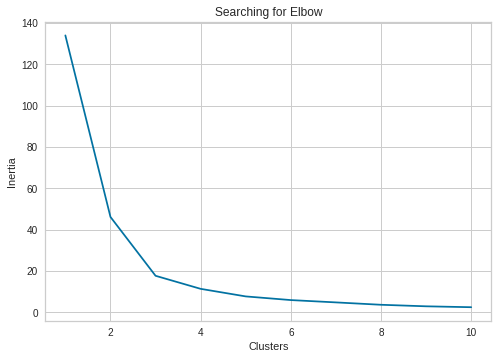


Result finding by Knee Locator function: 
3




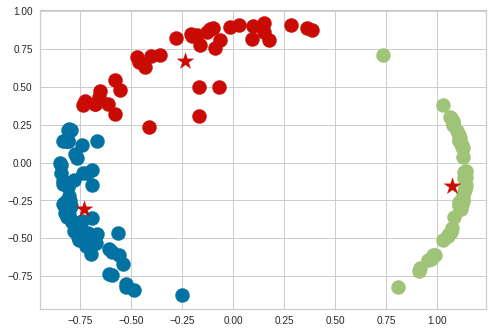

Accuracy:
(0.6503066625445627, 0.6600798095680834, 0.6551567909293411)


Categorical []
# 0  GLOBAL CAIM  35.88553113553113
# 1  GLOBAL CAIM  27.414349576849574
# 2  GLOBAL CAIM  39.26557500470544
# 3  GLOBAL CAIM  39.68121693121693

Caim splited scheme: 
{0: [4.3, 5.4, 5.8, 7.9], 1: [2.0, 2.7, 3.3, 4.4], 2: [1.0, 1.9, 4.2, 6.9], 3: [0.1, 0.6, 1.3, 2.5]}

Atribute labels by clusters get by CAIM method
{0: [(5.8, 7.9), (3.3, 4.4), (4.2, 6.9), (1.3, 2.5)], 1: [(4.3, 5.4), (2.0, 2.7), (1.0, 1.9), (0.1, 0.6)], 2: [(5.4, 5.8), (2.7, 3.3), (1.9, 4.2), (0.6, 1.3)]}


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 2 0 2 2 0 2 0 2 0 2 2 2 2 0 2 2 2
 0 0 0 0 0 2 2 2 2 2 2 0 0 2 2 2 2 0 2 2 2 2 2 0 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 2 0
 0 0]
Atribute percents accuracy by each cluster
[[[100, (5.8, 7.9), 61, 0], [16, (3.3, 4.4), 61, 51], [100, (4.2, 6.9), 61, 0], [100

,0,1,2,3,target,label_CAIBAL_standard,label_CAIBAL_alternative
0,5.1,3.5,1.4,0.2,1,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."
1,4.9,3.0,1.4,0.2,1,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."
2,4.7,3.2,1.3,0.2,1,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."
3,4.6,3.1,1.5,0.2,1,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."
4,5.0,3.6,1.4,0.2,1,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."
146,6.3,2.5,5.0,1.9,2,"(Attribute name: petal width (cm), Accuracy: 6...",
147,6.5,3.0,5.2,2.0,0,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."
148,6.2,3.4,5.4,2.3,0,"(Attribute name: petal width (cm), Accuracy: 1...","(Attribute name: sepal length (cm), Accuracy: ..."


In [76]:
print("IRIS")
X = load_iris()
# preprocess(X, y)
# X.feature_names
# X.target
pipeline(X.data, X.target, X.feature_names, 1, 15)
# print("\n\nWINE")
# X, y = load_wine(return_X_y=True)
# preprocess(X, y)
# print("\n\nCANCER")
# X, y = load_breast_cancer(return_X_y=True)
# preprocess(X, y)

- OBS: quando for adicionado paramentros de inicialização no kmeans ele altera a ordem dos valores das tags dos clustes. Onde, se no original a ordem dos rotulos forem [0,1,2] pode ficar [1,0,2] ou [0,2,1] ...

# Falta fazer
## Etapa 1 - ok
- Falta calcular o valor do acerto. Dado o numero de registro rotulado por um cluster, verficar a quantidade de registros para cada cluster e para cada atributo verificar qual a porcentagem deles que estão dentro dos valores de intervalo gerado pelo CAIM.
- Se para o cluster 1 houver 100 registro, e para esse base de dados houver 5 atributos, verificar o valor de cada atributo e contar a quantidade de vezes que os valores de cada atributo respeita a faixa discretizada pelo CAIM.
- Isso irá gerar a porcentagem de acerto para cada atributo. 


## Etapa 2
- Gerar os rotulos - ok
- Os rotulos serão Strings que contenha informações dos atributos que melhor respeitam as faixas de discretização gerada pelo CAIM (ordenado pela maior porcentagem) que estejam dentro de uma variancia predefinida.
- Ex:
  - Supondo uma base de dados com 3 clusters e 5 atributos. Para o cluster 1 os atributos atr1, atr3 e atr5 tiveram acuracia de 91%, 96% e 100% então as informações desses 3 atributos serão concatenadas no formato [Nome_do_atributo, Faixa_de_valores_discretizados_para_o_atributo, porcentagem_de_acerto}. A concatenação desses valores serão adicionados ao dataframe como o novo rotulos.